In [1]:
import torch
from torch import nn
import torch.nn.functional as F
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

import os
from PIL import Image
import glob
from tqdm import tqdm
from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt

# Download datasets

In [2]:

# training datasets
train_data = torchvision.datasets.DTD(root='data',
                                         split ='train',
                                         download=True,
                                         transform=transforms.ToTensor())

# testing datasets
test_data = torchvision.datasets.DTD(root='data',
                                        split ='test',
                                        download=True,
                                        transform=transforms.ToTensor())

100%|██████████| 625239812/625239812 [00:23<00:00, 27135779.12it/s]


Extracting data/dtd/dtd-r1.0.1.tar.gz to data/dtd


In [3]:
train_data


Dataset DTD
    Number of datapoints: 1880
    Root location: data
    split=train, partition=1
    StandardTransform
Transform: ToTensor()

In [4]:
image, label = train_data[0]
image, label

(tensor([[[1.0000, 1.0000, 1.0000,  ..., 0.9961, 1.0000, 0.9961],
          [1.0000, 1.0000, 1.0000,  ..., 0.9961, 0.9961, 1.0000],
          [1.0000, 1.0000, 1.0000,  ..., 1.0000, 0.9961, 1.0000],
          ...,
          [1.0000, 1.0000, 1.0000,  ..., 1.0000, 0.9961, 0.9922],
          [1.0000, 1.0000, 1.0000,  ..., 0.9961, 1.0000, 0.9961],
          [1.0000, 1.0000, 1.0000,  ..., 0.9961, 0.9961, 1.0000]],
 
         [[1.0000, 1.0000, 1.0000,  ..., 0.0000, 0.0000, 0.0000],
          [1.0000, 1.0000, 1.0000,  ..., 0.0000, 0.0039, 0.0039],
          [1.0000, 1.0000, 1.0000,  ..., 0.0000, 0.0000, 0.0039],
          ...,
          [1.0000, 1.0000, 1.0000,  ..., 0.0000, 0.0000, 0.0000],
          [1.0000, 1.0000, 1.0000,  ..., 0.0000, 0.0000, 0.0000],
          [1.0000, 1.0000, 1.0000,  ..., 0.0039, 0.0039, 0.0000]],
 
         [[1.0000, 1.0000, 1.0000,  ..., 0.4902, 0.5020, 0.4902],
          [1.0000, 1.0000, 1.0000,  ..., 0.4784, 0.5020, 0.4824],
          [1.0000, 1.0000, 1.0000,  ...,

In [5]:
image.shape

torch.Size([3, 480, 640])

In [6]:
len(train_data.classes)

47

Image shape: torch.Size([3, 480, 640])


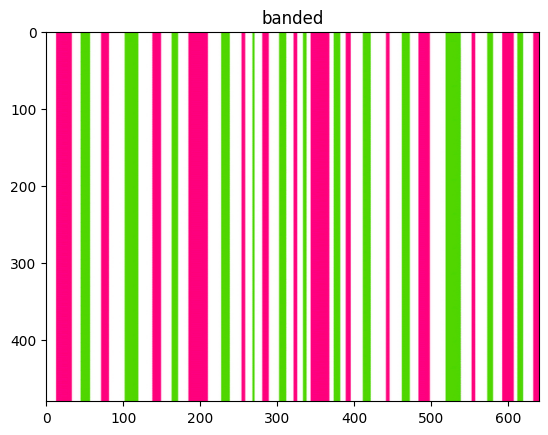

In [7]:
image, label = train_data[0]
class_names = train_data.classes

print(f"Image shape: {image.shape}")
# image = np.array(image)
img = np.transpose(image, (1, 2, 0))
plt.imshow(img.squeeze(), )
plt.title(class_names[label]);

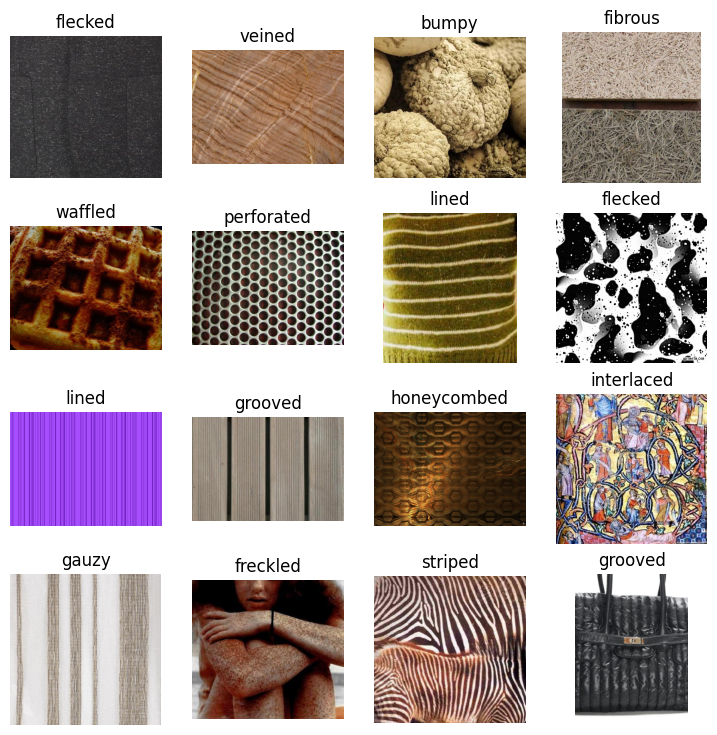

In [8]:
torch.manual_seed(42)
fig = plt.figure(figsize=(9, 9))
rows, cols = 4, 4
for i in range(1, rows * cols + 1):
    random_idx = torch.randint(0, len(train_data), size=[1]).item()
    img, label = train_data[random_idx]
    fig.add_subplot(rows, cols, i)
    img = np.transpose(img, (1, 2, 0))
    plt.imshow(img.squeeze())
    plt.title(class_names[label])
    plt.axis(False);

In [9]:
# Write transform for image
train_data_transform = transforms.Compose([
    transforms.Resize((300, 300)),
    # Flip the images randomly on the horizontal
    transforms.RandomHorizontalFlip(p=0.5), # p = probability of flip, 0.5 = 50% chance
    transforms.ColorJitter(brightness=0.2), # change the brightness of the image
    transforms.RandomRotation(degrees=15), # rotate the image by 15 degrees
    # Turn the image into a torch.Tensor
    transforms.ToTensor() # this also converts all pixel values from 0 to 255 to be between 0.0 and 1.0
])

# Create test transform
test_data_transform = transforms.Compose([
    transforms.Resize((300, 300)),
    transforms.ToTensor()
])

In [10]:

# training datasets
train_data = torchvision.datasets.DTD(root='data',
                                         split ='train',
                                         download=True,
                                         transform=train_data_transform)

# testing datasets
test_data = torchvision.datasets.DTD(root='data',
                                        split ='test',
                                        download=True,
                                        transform=test_data_transform)

In [11]:
train_data

Dataset DTD
    Number of datapoints: 1880
    Root location: data
    split=train, partition=1
    StandardTransform
Transform: Compose(
               Resize(size=(300, 300), interpolation=bilinear, max_size=None, antialias=True)
               RandomHorizontalFlip(p=0.5)
               ColorJitter(brightness=(0.8, 1.2), contrast=None, saturation=None, hue=None)
               RandomRotation(degrees=[-15.0, 15.0], interpolation=nearest, expand=False, fill=0)
               ToTensor()
           )

In [12]:
test_data

Dataset DTD
    Number of datapoints: 1880
    Root location: data
    split=test, partition=1
    StandardTransform
Transform: Compose(
               Resize(size=(300, 300), interpolation=bilinear, max_size=None, antialias=True)
               ToTensor()
           )

In [13]:
from torch.utils.data import DataLoader

# Setup the batch size hyperparameter
BATCH_SIZE = 32

# Turn datasets into iterables (batches)
train_dataloader = DataLoader(train_data, # dataset to turn into iterable
    batch_size=BATCH_SIZE, # how many samples per batch?
    shuffle=True # shuffle data every epoch?
)

test_dataloader = DataLoader(test_data,
    batch_size=BATCH_SIZE,
    shuffle=False # don't necessarily have to shuffle the testing data
)

# Let's check out what we've created
print(f"Dataloaders: {train_dataloader, test_dataloader}")
print(f"Length of train dataloader: {len(train_dataloader)} batches of {BATCH_SIZE}")
print(f"Length of test dataloader: {len(test_dataloader)} batches of {BATCH_SIZE}")

Dataloaders: (<torch.utils.data.dataloader.DataLoader object at 0x7dfae0953b50>, <torch.utils.data.dataloader.DataLoader object at 0x7dfae3662680>)
Length of train dataloader: 59 batches of 32
Length of test dataloader: 59 batches of 32


In [14]:
import requests
from pathlib import Path

# Download helper functions from Learn PyTorch repo (if not already downloaded)
if Path("helper_functions.py").is_file():
  print("helper_functions.py already exists, skipping download")
else:
  print("Downloading helper_functions.py")
  # Note: you need the "raw" GitHub URL for this to work
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)

In [15]:
# Import accuracy metric
from helper_functions import accuracy_fn # Note: could also use torchmetrics.Accuracy(task = 'multiclass', num_classes=len(class_names)).to(device)


In [16]:
from timeit import default_timer as timer
def print_train_time(start: float, end: float, device: torch.device = None):
    """Prints difference between start and end time.

    Args:
        start (float): Start time of computation (preferred in timeit format).
        end (float): End time of computation.
        device ([type], optional): Device that compute is running on. Defaults to None.

    Returns:
        float: time between start and end in seconds (higher is longer).
    """
    total_time = end - start
    print(f"Train time on {device}: {total_time:.3f} seconds")
    return total_time

In [17]:
# class CifarModelV2(nn.Module):
#     def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
#         super().__init__()

#         # BLOCK 1
#         self.block_1 = nn.Sequential(
#             nn.Conv2d(in_channels=input_shape,
#                       out_channels=hidden_units,
#                       kernel_size=3, # how big is the square that's going over the image?
#                       stride=1, # default
#                       padding=1),# options = "valid" (no padding) or "same" (output has same shape as input) or int for specific number
#             nn.ReLU(),
#             nn.Conv2d(in_channels=hidden_units,
#                       out_channels=hidden_units,
#                       kernel_size=3,
#                       stride=1,
#                       padding=1),
#             nn.ReLU(),
#             nn.Conv2d(in_channels=hidden_units,
#                       out_channels=hidden_units,
#                       kernel_size=3,
#                       stride=1,
#                       padding=1),
#             nn.ReLU(),
#             nn.MaxPool2d(kernel_size=2,
#                          stride=2) # default stride value is same as kernel_size
#         )

#         # BLOCK 2
#         self.block_2 = nn.Sequential(
#             nn.Conv2d(hidden_units, hidden_units, 3, padding=1),
#             nn.ReLU(),
#             nn.Conv2d(hidden_units, hidden_units, 3, padding=1),
#             nn.ReLU(),
#             nn.Conv2d(hidden_units, hidden_units, 3, padding=1),
#             nn.ReLU(),
#             nn.MaxPool2d(2)
#         )

#         # CLASSIFIER BLOCK
#         self.classifier = nn.Sequential(
#             nn.Flatten(),
#             nn.Linear(in_features=hidden_units*75*75, out_features=512),
#             nn.ReLU(),
#             nn.Linear(in_features=512, out_features=128),
#             nn.ReLU(),
#             nn.Linear(in_features=128, out_features=64),
#             nn.ReLU(),
#             nn.Linear(in_features=64, out_features=32),
#             nn.ReLU(),
#             nn.Linear(in_features=32, out_features=output_shape),
#         )


#     def forward(self, x):
#         x = self.block_1(x)
#         x = self.block_2(x)
#         x = self.classifier(x)
#         return x

In [18]:
# Setup device-agnostic code
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [19]:
# model_2 = CifarModelV2(input_shape=3, hidden_units=64, output_shape=len(train_data.classes)).to(device)
# loss_fn = nn.CrossEntropyLoss()
# optimizer = torch.optim.SGD(params=model_2.parameters(), lr=0.05)


In [20]:
# model_2


In [21]:
def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer):
    # Put model in train mode
    model.train()

    # Setup train loss and train accuracy values
    train_loss, train_acc = 0, 0

    # Loop through data loader data batches
    for batch, (X, y) in enumerate(dataloader):
        # Send data to target device
        X, y = X.to(device), y.to(device)

        # 1. Forward pass
        y_pred = model(X)

        # 2. Calculate  and accumulate loss
        loss = loss_fn(y_pred, y)
        train_loss += loss.item()

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. Optimizer step
        optimizer.step()

        # Calculate and accumulate accuracy metric across all batches
        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        train_acc += (y_pred_class == y).sum().item()/len(y_pred)

    # Adjust metrics to get average loss and accuracy per batch
    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)
    return train_loss, train_acc

def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module):
    # Put model in eval mode
    model.eval()

    # Setup test loss and test accuracy values
    test_loss, test_acc = 0, 0

    # Turn on inference context manager
    with torch.inference_mode():
        # Loop through DataLoader batches
        for batch, (X, y) in enumerate(dataloader):
            # Send data to target device
            X, y = X.to(device), y.to(device)

            # 1. Forward pass
            test_pred_logits = model(X)

            # 2. Calculate and accumulate loss
            loss = loss_fn(test_pred_logits, y)
            test_loss += loss.item()

            # Calculate and accumulate accuracy
            test_pred_labels = test_pred_logits.argmax(dim=1)
            test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))

    # Adjust metrics to get average loss and accuracy per batch
    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / len(dataloader)
    return test_loss, test_acc

from tqdm.auto import tqdm

# 1. Take in various parameters required for training and test steps
def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module = nn.CrossEntropyLoss(),
          epochs: int = 5):

    # 2. Create empty results dictionary
    results = {"train_loss": [],
        "train_acc": [],
        "test_loss": [],
        "test_acc": []
    }

    # 3. Loop through training and testing steps for a number of epochs
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=model,
                                           dataloader=train_dataloader,
                                           loss_fn=loss_fn,
                                           optimizer=optimizer)
        test_loss, test_acc = test_step(model=model,
            dataloader=test_dataloader,
            loss_fn=loss_fn)

        # 4. Print out what's happening
        print(
            f"Epoch: {epoch+1} | "
            f"train_loss: {train_loss:.4f} | "
            f"train_acc: {train_acc:.4f} | "
            f"test_loss: {test_loss:.4f} | "
            f"test_acc: {test_acc:.4f}"
        )

        # 5. Update results dictionary
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)

    # 6. Return the filled results at the end of the epochs
    return results

In [29]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class VGG16(nn.Module):
    def __init__(self, num_classes=1000):
        super(VGG16, self).__init__()

        # Convolutional layers
        self.conv_layers = nn.Sequential(
            # Block 1
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # Block 2
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # Block 3
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # Block 4
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # Block 5
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        # Fully connected layers
        self.fc_layers = nn.Sequential(
            nn.Linear(512 * 9 * 9, 2048),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(2048, 2048),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(2048, num_classes)
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)  # Flatten the tensor
        x = self.fc_layers(x)
        return x


In [30]:
import torch.optim as optim

# Check for available GPUs and set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Initialize the model and move it to the appropriate device
model = VGG16(num_classes=len(train_data.classes))  # Example for CIFAR-10 dataset
# if torch.cuda.device_count() > 1:
#     print("Using", torch.cuda.device_count(), "GPUs!")
#     model = nn.DataParallel(model)

model.to(device)

Using device: cuda


VGG16(
  (conv_layers): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilat

In [31]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model.parameters(), lr=0.05)

In [ ]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Set number of epochs
NUM_EPOCHS = 100

from timeit import default_timer as timer
start_time = timer()

model_results = train(model=model,
                        train_dataloader=train_dataloader,
                        test_dataloader=test_dataloader,
                        optimizer=optimizer,
                        loss_fn=loss_fn,
                        epochs=NUM_EPOCHS)

# End the timer and print out how long it took
end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 3.8512 | train_acc: 0.0201 | test_loss: 3.8502 | test_acc: 0.0212
Epoch: 2 | train_loss: 3.8510 | train_acc: 0.0132 | test_loss: 3.8502 | test_acc: 0.0212
Epoch: 3 | train_loss: 3.8513 | train_acc: 0.0117 | test_loss: 3.8502 | test_acc: 0.0212
Epoch: 4 | train_loss: 3.8514 | train_acc: 0.0143 | test_loss: 3.8501 | test_acc: 0.0212
Epoch: 5 | train_loss: 3.8512 | train_acc: 0.0175 | test_loss: 3.8501 | test_acc: 0.0212
Epoch: 6 | train_loss: 3.8512 | train_acc: 0.0164 | test_loss: 3.8501 | test_acc: 0.0212
Epoch: 7 | train_loss: 3.8513 | train_acc: 0.0212 | test_loss: 3.8501 | test_acc: 0.0212
Epoch: 8 | train_loss: 3.8512 | train_acc: 0.0169 | test_loss: 3.8501 | test_acc: 0.0212
Epoch: 9 | train_loss: 3.8511 | train_acc: 0.0207 | test_loss: 3.8501 | test_acc: 0.0212
Epoch: 10 | train_loss: 3.8510 | train_acc: 0.0192 | test_loss: 3.8501 | test_acc: 0.0212
